In [1]:
"""
Created on 9/7/2022

@author: JJ
"""

'\nCreated on 9/7/2022\n\n@author: JJ\n'

In [2]:
import os, re, sys
import numpy as np
import pandas as pd
from math import log
import random
import scipy.io
import tensorflow as tf
import csv

2022-10-12 15:22:38.927811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import (
    l2, 
    l1, 
    l1_l2
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import (
    activations, 
    initializers, 
    regularizers, 
    constraints
)

In [4]:
#import from python files
from model import build_model

In [5]:
num_threads = 8
# Maximum number of threads to use for OpenMP parallel regions.
os.environ["OMP_NUM_THREADS"] = "8"
# Without setting below 2 environment variables, it didn't work for me. Thanks to @cjw85 
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [6]:
# in a well-defined initial state.
random.seed
np.random.seed(1337)
tf.random.set_seed(1337)
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
import keras_tuner as kt
from collections import defaultdict

In [7]:
all_pep, all_mhc, all_target = np.load('/home/jjia1/jjia1/viralepitope/all_pep_converted.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_mhc_converted.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_target_converted.npy')

In [8]:
def oversampling(pep, mhc, target):
    pos = np.where(target==1)
    neg = np.where(target==0)

    pep_pos, mhc_pos, target_pos = pep[pos], mhc[pos], target[pos]
    pep_neg, mhc_neg, target_neg = pep[neg], mhc[neg], target[neg]

    pep_pos, mhc_pos, target_pos = resample(pep_pos, mhc_pos, target_pos, n_samples= len(target_neg), random_state = 1337)
    pep_neg, mhc_neg, target_neg = resample(pep_neg, mhc_neg, target_neg, n_samples= len(target_neg), random_state = 1337)


    pep = np.concatenate([pep_pos, pep_neg])
    mhc = np.concatenate([mhc_pos, mhc_neg])
    target = np.concatenate([target_pos, target_neg])

    pep, mhc, target = shuffle(pep, mhc, target, random_state = 1337)
    return pep, mhc, target
    

In [9]:
pep_bal, mhc_bal, target_bal = oversampling(all_pep, all_mhc, all_target)

In [10]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 5)

In [11]:
train_pep, test_pep, train_mhc, test_mhc, train_target, test_target = train_test_split(pep_bal, mhc_bal, target_bal, test_size = 0.2, stratify= target_bal)

In [12]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)    
allprobas_=np.array([]) 
all_labels=np.array([])

In [13]:
for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
    training_pep = train_pep[train]
    training_mhc = train_mhc[train]
    training_target = train_target[train]
    
    validation_pep = train_pep[test]
    validation_mhc = train_mhc[test]
    validation_target = train_target[test]

    mc = ModelCheckpoint('model/Upsample/model_' +str(i)+'.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    model = build_model(training_pep, training_mhc)
    model.summary()

    model.fit([training_pep,training_mhc], 
            training_target,
            batch_size=512,
            epochs = 100,
            shuffle=True,
            callbacks=[es, mc],
            validation_data=([validation_pep,validation_mhc], validation_target),
            verbose=1)  
    del model

    saved_model = build_model(training_pep, training_mhc)
    saved_model.load_weights('model/Upsample/model_' +str(i)+'.h5')
    probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
    allprobas_ = np.append(allprobas_, probas_)           
    all_labels = np.append(all_labels, validation_target)
    del saved_model


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-10-12 15:24:12.216704: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-12 15:24:12.217572: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-12 15:24:12.217591: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-12 15:24:12.217615: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sbcphaplp001.uthouston.edu): /proc/driver/nvidia/version does not exist
2022-10-12 15:24:12.217931: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other op

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
peptide (InputLayer)            [(None, 30, 20)]     0                                            
__________________________________________________________________________________________________
mhc (InputLayer)                [(None, 34, 20)]     0                                            
__________________________________________________________________________________________________
conv1_pep (Conv1D)              (None, 30, 256)      25856       peptide[0][0]                    
__________________________________________________________________________________________________
conv1_mhc (Conv1D)              (None, 34, 256)      25856       mhc[0][0]                        
______________________________________________________________________________________________

2022-10-12 15:24:14.305584: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2640045600 exceeds 10% of free system memory.
2022-10-12 15:24:18.417034: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2992051680 exceeds 10% of free system memory.
2022-10-12 15:24:21.267953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-12 15:24:21.268505: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/100
2149/2149 [==============================] - 338s 156ms/step - loss: 0.4532 - accuracy: 0.7890 - auc: 0.8638 - val_loss: 0.3791 - val_accuracy: 0.8348 - val_auc: 0.9077

Epoch 00001: val_accuracy improved from -inf to 0.83481, saving model to model/Upsample/model_0.h5
Epoch 2/100
2149/2149 [==============================] - 363s 169ms/step - loss: 0.3912 - accuracy: 0.8286 - auc: 0.9016 - val_loss: 0.3653 - val_accuracy: 0.8434 - val_auc: 0.9160

Epoch 00002: val_accuracy improved from 0.83481 to 0.84338, saving model to model/Upsample/model_0.h5
Epoch 3/100
2149/2149 [==============================] - 350s 163ms/step - loss: 0.3796 - accuracy: 0.8352 - auc: 0.9076 - val_loss: 0.3526 - val_accuracy: 0.8513 - val_auc: 0.9209

Epoch 00003: val_accuracy improved from 0.84338 to 0.85129, saving model to model/Upsample/model_0.h5
Epoch 4/100
2149/2149 [==============================] - 334s 155ms/step - loss: 0.3700 - accuracy: 0.8409 - auc: 0.9125 - val_loss: 0.3450 - val_accur

2022-10-12 20:40:46.658078: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2640045600 exceeds 10% of free system memory.
2022-10-12 20:40:50.649680: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2992051680 exceeds 10% of free system memory.


Epoch 1/100
2149/2149 [==============================] - 266s 122ms/step - loss: 0.4670 - accuracy: 0.7798 - auc: 0.8538 - val_loss: 0.3808 - val_accuracy: 0.8337 - val_auc: 0.9072

Epoch 00001: val_accuracy improved from -inf to 0.83374, saving model to model/Upsample/model_1.h5
Epoch 2/100
2149/2149 [==============================] - 231s 107ms/step - loss: 0.3923 - accuracy: 0.8283 - auc: 0.9010 - val_loss: 0.3656 - val_accuracy: 0.8428 - val_auc: 0.9153

Epoch 00002: val_accuracy improved from 0.83374 to 0.84278, saving model to model/Upsample/model_1.h5
Epoch 3/100
2149/2149 [==============================] - 221s 103ms/step - loss: 0.3809 - accuracy: 0.8346 - auc: 0.9070 - val_loss: 0.3540 - val_accuracy: 0.8501 - val_auc: 0.9208

Epoch 00003: val_accuracy improved from 0.84278 to 0.85010, saving model to model/Upsample/model_1.h5
Epoch 4/100
2149/2149 [==============================] - 225s 104ms/step - loss: 0.3731 - accuracy: 0.8384 - auc: 0.9111 - val_loss: 0.3455 - val_accur

2022-10-13 01:56:38.612691: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2640045600 exceeds 10% of free system memory.


Epoch 1/100
2149/2149 [==============================] - 219s 101ms/step - loss: 0.4554 - accuracy: 0.7877 - auc: 0.8625 - val_loss: 0.3794 - val_accuracy: 0.8355 - val_auc: 0.9081

Epoch 00001: val_accuracy improved from -inf to 0.83551, saving model to model/Upsample/model_2.h5
Epoch 2/100
2149/2149 [==============================] - 272s 127ms/step - loss: 0.3918 - accuracy: 0.8282 - auc: 0.9013 - val_loss: 0.3638 - val_accuracy: 0.8427 - val_auc: 0.9157

Epoch 00002: val_accuracy improved from 0.83551 to 0.84268, saving model to model/Upsample/model_2.h5
Epoch 3/100
2149/2149 [==============================] - 286s 133ms/step - loss: 0.3806 - accuracy: 0.8348 - auc: 0.9073 - val_loss: 0.3531 - val_accuracy: 0.8503 - val_auc: 0.9215

Epoch 00003: val_accuracy improved from 0.84268 to 0.85031, saving model to model/Upsample/model_2.h5
Epoch 4/100
2149/2149 [==============================] - 294s 137ms/step - loss: 0.3714 - accuracy: 0.8398 - auc: 0.9120 - val_loss: 0.3435 - val_accur

0.9601906128895448
0.9519102563934142
0.9615853815950092
0.9539652407053858
0.9580340133483699
0.9495987854660669
0.9587547049725781
0.9502308306802089


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


0.9607467081239032
0.9523920842502234


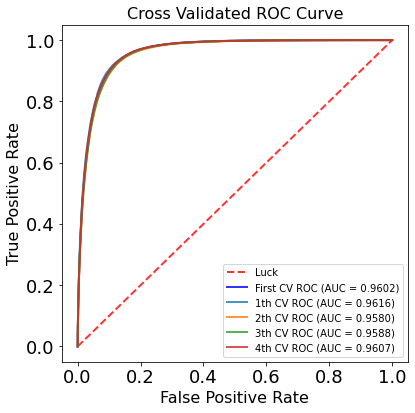

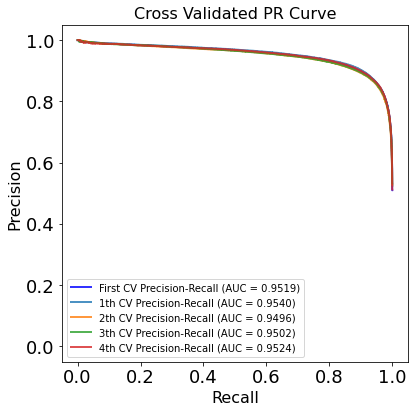

In [14]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
    training_pep = train_pep[train]
    training_mhc = train_mhc[train]
    training_target = train_target[train]
    
    validation_pep = train_pep[test]
    validation_mhc = train_mhc[test]
    validation_target = train_target[test]

    if i == 0:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/Upsample/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
        allprobas_ = np.append(allprobas_, probas_)           
        all_labels = np.append(all_labels, validation_target)
        del saved_model

        fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
        aupr = average_precision_score(all_labels, allprobas_)
        print(roc_auc)
        print(aupr)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr, color='b',
                label=r'First CV ROC (AUC = %0.4f)' % (roc_auc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(recall, precision, color='b',
                label=r'First CV Precision-Recall (AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")

    else:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/Upsample/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
        allprobas_ = np.append(allprobas_, probas_)           
        all_labels = np.append(all_labels, validation_target)
        del saved_model
        
        fpr, tpr, thresholds = roc_curve(validation_target, probas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(validation_target, probas_)
        aupr = average_precision_score(validation_target, probas_)
        print(roc_auc)
        print(aupr)

        ax1.plot(fpr, tpr,  
        label=str(i)+'th CV ROC (AUC = %0.4f)' % (roc_auc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(recall, precision, 
        label=str(i)+'th CV Precision-Recall (AUC = %0.4f)' % (aupr),
        lw=2, alpha=.8)
        ax2.legend(loc="lower left")

In [15]:
figure1.savefig('figures/Upsample_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/Upsample_5_fold_prc.jpg', dpi=300, bbox_inches = 'tight')

0.9600058575997011


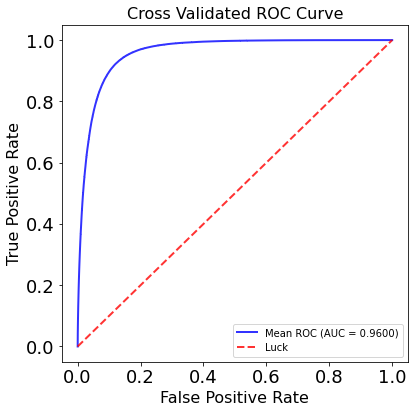

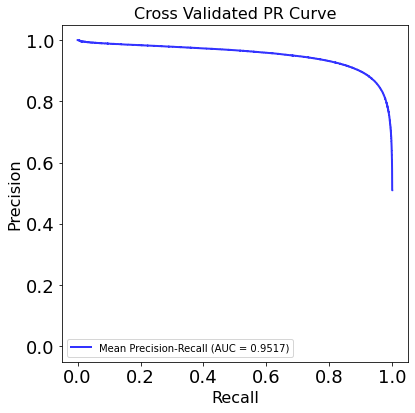

In [16]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
figure1.savefig('figures/Upsample_mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels, allprobas_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
figure2.savefig('figures/Upsample_mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')


In [17]:
allprobas2_=np.array([]) 
all_labels2=np.array([])

0.9618210368621795
0.9539824742856445
0.9613504642727247
0.9537742541857192
0.9586055605320187
0.9504375450590029
0.9588699901611055
0.9504687736942656
0.9611822644685772
0.952989955714713


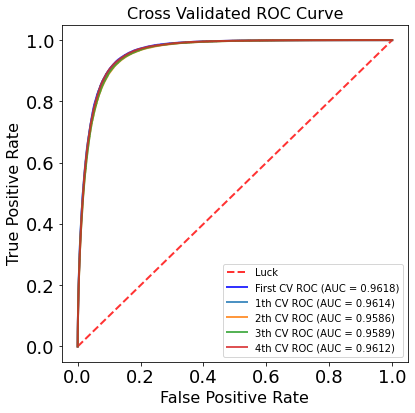

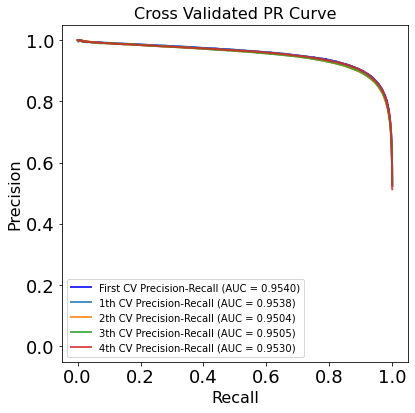

In [18]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for i in range(5):
    if i == 0:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/Upsample/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(test_pep),np.array(test_mhc)])
        allprobas2_ = np.append(allprobas2_, probas_)           
        all_labels2 = np.append(all_labels2, test_target)
        del saved_model

        fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
        aupr = average_precision_score(all_labels2, allprobas2_)
        print(roc_auc)
        print(aupr)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr, color='b',
                label=r'First CV ROC (AUC = %0.4f)' % (roc_auc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(recall, precision, color='b',
                label=r'First CV Precision-Recall (AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")

    else:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/Upsample/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(test_pep),np.array(test_mhc)])
        allprobas2_ = np.append(allprobas2_, probas_)           
        all_labels2 = np.append(all_labels2, test_target)
        del saved_model
        
        fpr, tpr, thresholds = roc_curve(test_target, probas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(test_target, probas_)
        aupr = average_precision_score(test_target, probas_)
        print(roc_auc)
        print(aupr)

        ax1.plot(fpr, tpr,
        label=str(i)+'th CV ROC (AUC = %0.4f)' % (roc_auc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(recall, precision, 
        label=str(i)+'th CV Precision-Recall (AUC = %0.4f)' % (aupr),
        lw=2, alpha=.8)
        ax2.legend(loc="lower left")

figure1.savefig('figures/Upsample_test_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/Upsample_test_5_fold_prc.jpg', dpi=300, bbox_inches = 'tight')

0.9602952652940485


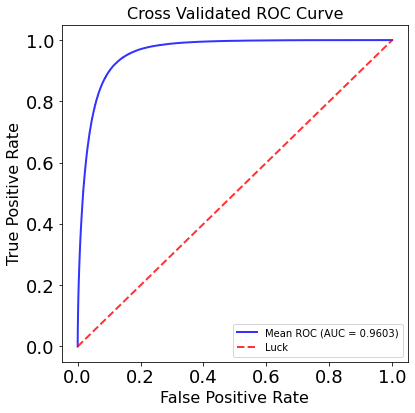

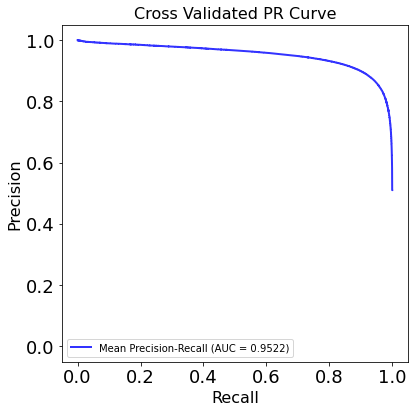

In [19]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
figure1.savefig('figures/Upsample_test_mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels2, allprobas2_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
figure2.savefig('figures/Upsample_test_mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')
